In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
import re
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
# fix random seed for reproducibility
np.random.seed(7)
%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading the wikipedia pages articles 

In [2]:
politics_data = pd.read_csv("politics_full.csv")
sports_data = pd.read_csv("sports_full.csv")
history_data = pd.read_csv("history_full.csv")
culture_data = pd.read_csv("culture_full.csv")
comp_science_data = pd.read_csv("comp_science_full.csv")

Mapping different categories to integers

In [3]:
category_dict = {
    1: 'politics',
    2: 'sports',
    3: 'history',
    4: 'culture',
    5: 'computer_science'
}

Removing newlines and punctuations from raw content of the pages

In [4]:
translator = str.maketrans('', '', string.punctuation)
politics_data['content'] = politics_data['content'].map(lambda x: re.sub('\n', ' ', x))\
.map(lambda x: x.translate(translator))
politics_data['category'] = [1]* len(politics_data)

sports_data['content'] = sports_data['content'].map(lambda x: re.sub('\n', ' ', x))\
.map(lambda x: x.translate(translator))
sports_data['category'] = [2]* len(sports_data)

history_data['content'] = history_data['content'].map(lambda x: re.sub('\n', ' ', x))\
.map(lambda x: x.translate(translator))
history_data['category'] = [3]* len(history_data)

culture_data['content'] = culture_data['content'].map(lambda x: re.sub('\n', ' ', x))\
.map(lambda x: x.translate(translator))
culture_data['category'] = [4]* len(culture_data)

comp_science_data['content'] = comp_science_data['content'].map(lambda x: re.sub('\n', ' ', x))\
.map(lambda x: x.translate(translator))
comp_science_data['category'] = [5]* len(comp_science_data)


In [5]:
comp_science_data.head()

,Unnamed: 0,title,pageid,length,content,category
0,0,Artificial intelligence,1164,231620,Artificial intelligence AI also machine intell...,5
1,1,Comparison of programming languages (string fu...,3681422,109570,String functions are used in computer programm...,5
2,2,Geographic information system,12398,77692,A geographic information system GIS is a syste...,5
3,3,Computational creativity,16300571,61153,Computational creativity also known as artific...,5
4,4,Computational phylogenetics,3986130,58742,Computational phylogenetics is the application...,5


Union the 5 dataframes and make a new dataframe

In [6]:
#union data frames
df_list = [politics_data, sports_data, history_data, culture_data, comp_science_data]
full_df = pd.concat(df_list)

In [7]:
#shuffling the rows of dataframe
full_df = full_df.sample(frac=1)

In [8]:
contents = list(full_df['content'])
targets = np.array(full_df['category'])

making the TF IDF matrix of the documents. We choose to remove the words that appear in less than 5 documnets in the corpus.

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=5)
#vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(contents)
vectors.shape

(5000, 31700)

As we can see the resulting matrix is relatively sparse

In [10]:
print('total number of zeros:', vectors.nnz)
print('{} average zero per data sample'.format(vectors.nnz / float(vectors.shape[0])))

total number of zeros: 1505991
301.1982 average zero per data sample


It is desirable to have equal number of samples in both training and test corpus. So we first shuffle the indicies for each of the classes and then we pick 90% data from each of the classes for training and 10% for testing.

In [11]:
indicies_1 = [i for i,x in enumerate(targets) if x == 1]
np.random.shuffle(indicies_1)
indicies_2 = [i for i,x in enumerate(targets) if x == 2]
np.random.shuffle(indicies_2)
indicies_3 = [i for i,x in enumerate(targets) if x == 3]
np.random.shuffle(indicies_3)
indicies_4 = [i for i,x in enumerate(targets) if x == 4]
np.random.shuffle(indicies_4)
indicies_5 = [i for i,x in enumerate(targets) if x == 5]
np.random.shuffle(indicies_5)

In [12]:
ratio = 0.9
train_indicies = indicies_1[0:int(ratio*len(indicies_1))]\
+indicies_2[0:int(ratio*len(indicies_2))]+indicies_3[0:int(ratio*len(indicies_3))]\
+indicies_4[0:int(ratio*len(indicies_4))]+indicies_5[0:int(ratio*len(indicies_5))]
np.random.shuffle(train_indicies)

In [13]:
test_indicies = indicies_1[int(ratio*len(indicies_1)):]\
+indicies_2[int(ratio*len(indicies_2)):]+indicies_3[int(ratio*len(indicies_3)):]\
+indicies_4[int(ratio*len(indicies_4)):]+indicies_5[int(ratio*len(indicies_5)):]
np.random.shuffle(test_indicies)

final training and test vectors

In [14]:
train_vectors = vectors[train_indicies]
test_vectors = vectors[test_indicies]
#------------
train_targets = targets[train_indicies]
test_targets = targets[test_indicies]

In [15]:
feature_names = vectorizer.get_feature_names()
feature_names[:5]

['00', '000', '0000', '001', '007']

## Random forest Classifier

Fisrt we choose to train a random forest classifier. Random forset is bassically a collection of simple models (decision trees), so as we increase the number of trees the model becomes more complex and hence tends to overfit.

In the first try we fit a random forest model with default parameters

In [160]:
RFclassifier = RandomForestClassifier(n_jobs=-1)
RFclassifier.fit(train_vectors,train_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [161]:
test_res = RFclassifier.predict(test_vectors)

In [162]:
accuracy = np.mean([test_res[i]==test_targets[i] for i in range(len(test_targets))])
print('accuracy = {}%'.format(accuracy*100))

accuracy = 74.6%


Hyperparameter tuning for Random Forest parameters for getting better results.

In [163]:
n_estimator = [i for i in range(100,1100,100)]
max_depth = [i for i in range(50,100,10)]
clf = GridSearchCV(estimator=RFclassifier, param_grid={'n_estimators':n_estimator,'max_depth':max_depth},n_jobs=-1)
clf.fit(train_vectors,train_targets)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [50, 60, 70, 80, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The dataframe below shows the best train and test score and their associated parameters

In [164]:
df = pd.DataFrame(clf.cv_results_)
df.sort_values('rank_test_score',inplace=True)
df.head()

/home/ajalloei/.conda/envs/ahmad_virtualenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ajalloei/.conda/envs/ahmad_virtualenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ajalloei/.conda/envs/ahmad_virtualenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.wa

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
29,163.670287,7.145987,0.821556,0.990333,70,1000,"{'max_depth': 70, 'n_estimators': 1000}",1,0.814667,0.992333,0.823333,0.990333,0.826667,0.988333,11.686875,1.077985,0.005058,0.001633
8,125.858999,6.559073,0.821111,0.989222,50,900,"{'max_depth': 50, 'n_estimators': 900}",2,0.813333,0.991667,0.825333,0.990000,0.824667,0.986000,1.134310,0.123111,0.005506,0.002378
9,150.759535,7.794189,0.821111,0.989111,50,1000,"{'max_depth': 50, 'n_estimators': 1000}",2,0.814667,0.991667,0.823333,0.989667,0.825333,0.986000,7.780510,0.247463,0.004629,0.002347
16,119.400220,5.967087,0.821111,0.989778,60,700,"{'max_depth': 60, 'n_estimators': 700}",2,0.814000,0.992000,0.830000,0.990333,0.819333,0.987000,5.114454,0.159478,0.006652,0.002079
18,157.372489,7.499259,0.820889,0.989778,60,900,"{'max_depth': 60, 'n_estimators': 900}",5,0.814667,0.992000,0.826667,0.990333,0.821333,0.987000,2.454800,0.460805,0.004909,0.002079


In [165]:
best_RFclassifier = RandomForestClassifier(n_estimators=1000, max_depth=70, n_jobs=-1)
best_RFclassifier.fit(train_vectors,train_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [173]:
print('accuracy for best RF classifier = {}%'.format(best_RFclassifier.score(test_vectors, test_targets)*100))

accuracy for best RF classifier = 82.8%


## Naive Bayes Classifier

Second classifier is Multinomial Naive Classifier which is relatively a simple model and the learning time is quiet fast. It is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work. (http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [198]:
clf = MultinomialNB().fit(train_vectors, train_targets)

In [199]:
print('accuracy for Multinomial Naive Bayes classifier = {}%'.format(clf.score(test_vectors, test_targets)*100))

accuracy for Multinomial Naive Bayes classifier = 84.0%


Tuning $\alpha $ parameter for the classifier. This is basically the smoothing parameter for the classifier

In [208]:
alpha = [i/10 for i in range(1,20,1)]
clf = GridSearchCV(estimator=MultinomialNB(), param_grid={'alpha':alpha},n_jobs=-1, cv=10, return_train_score=True)
clf.fit(train_vectors,train_targets)

GridSearchCV(cv=10, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [209]:
df = pd.DataFrame(clf.cv_results_)
df.sort_values('rank_test_score',inplace=True)
df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.337634,0.010722,0.845778,0.933333,0.2,{'alpha': 0.2},1,0.866667,0.933333,0.853333,...,0.853333,0.931605,0.831111,0.934074,0.851111,0.933086,0.023646,0.002840,0.012500,0.001059
0,0.236525,0.008792,0.843333,0.940889,0.1,{'alpha': 0.1},2,0.860000,0.940741,0.851111,...,0.848889,0.938272,0.831111,0.940000,0.848889,0.940247,0.105323,0.004253,0.010669,0.001646
2,0.307943,0.011466,0.842889,0.927333,0.3,{'alpha': 0.3},3,0.866667,0.927654,0.842222,...,0.855556,0.925679,0.824444,0.927901,0.842222,0.927654,0.019358,0.002061,0.012998,0.001018
3,0.295297,0.012531,0.840000,0.922123,0.4,{'alpha': 0.4},4,0.862222,0.923951,0.833333,...,0.853333,0.920000,0.817778,0.922222,0.833333,0.923210,0.023494,0.001517,0.013481,0.001750
4,0.229445,0.008891,0.838222,0.917654,0.5,{'alpha': 0.5},5,0.851111,0.918519,0.835556,...,0.851111,0.915802,0.820000,0.918272,0.831111,0.919012,0.091586,0.003984,0.010968,0.001185


In [212]:
best_NB = MultinomialNB(alpha=0.2).fit(train_vectors, train_targets)
print('accuracy for best Multinomial Naive Bayes classifier = {}%'.format(best_NB.score(test_vectors, test_targets)*100))

accuracy for best Multinomial Naive Bayes classifier = 84.8%


## Logistic Regression

Training a multiclass Logestic Regression for the task. We use the Logistic Regression cross validation function. The rgularization parameter will vary between $10^{-4}$ and $10^{4}$. We choose to have 20 different values in this interval

In [215]:
clf = LogisticRegressionCV(Cs=20, multi_class='multinomial', n_jobs=-1)
clf.fit(train_vectors, train_targets)

LogisticRegressionCV(Cs=20, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [248]:
print('accuracy for best Logistic Regression classifier = {}%'.format(clf.score(test_vectors, test_targets)*100))

accuracy for best Logistic Regression classifier = 87.8%


In [236]:
scors = np.concatenate((np.mean(clf.scores_[1], axis = 0), np.mean(clf.scores_[2], axis = 0)
                        , np.mean(clf.scores_[3], axis = 0), np.mean(clf.scores_[4], axis = 0)
                        , np.mean(clf.scores_[5], axis = 0)), axis=0)
scors = scors.reshape((5,20))

The graph below shows the best regularizer value that gives the best accuracy

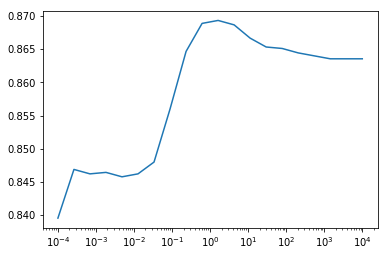

In [241]:
plt.semilogx(clf.Cs_, np.mean(scors, axis=0))
plt.show()


In [249]:
test_res = clf.predict(test_vectors)
cnf_matrix = confusion_matrix(test_targets, test_res)

Confusion matrix, without normalization


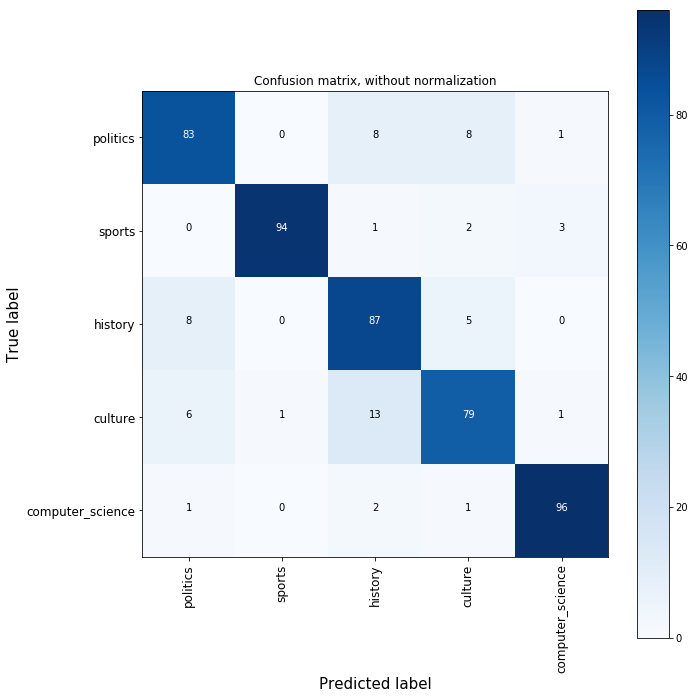

In [252]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(category_dict))
    plt.xticks(tick_marks, category_dict.values(), rotation=90,fontsize=12)
    plt.yticks(tick_marks, category_dict.values(), fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=newsgroups.target_names,
                      title='Confusion matrix, without normalization')

The confusion matrix show wich classes where misclassified with each other. As expected similar categories (culture, politics and history) were misclassified mostly.

## MLP classifier
The next classifier is a multi layer perceptron neural network. MLP is a feedforward artificial neural network and consists of at least three layers of nodes. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. hrefIt can distinguish data that is not linearly separable. (<a href="https://en.wikipedia.org/wiki/Multilayer_perceptron">ref</a>)

Training MLP could be time consuming and therefore i choosed to tune only the tuning parameter ($\alpha$) for this classifier. All other parameters are the default ones from sklearn. (i.e. network has only one hidden layer with 100 neurons) 

In [45]:
alpha = np.logspace(-5, 3, 5)
clf = GridSearchCV(estimator=MLPClassifier(verbose=True), param_grid={'alpha':alpha},n_jobs=-1, return_train_score=True)
clf.fit(train_vectors,train_targets)

Iteration 1, loss = 1.52194577
Iteration 1, loss = 1.52083370
Iteration 1, loss = 3.22521775
Iteration 1, loss = 163.68572051
Iteration 1, loss = 1.51941495
Iteration 1, loss = 3.22488165
Iteration 1, loss = 1.55507851
Iteration 1, loss = 1.55658394
Iteration 1, loss = 163.68573255
Iteration 1, loss = 1.55362878
Iteration 1, loss = 1.52120972
Iteration 1, loss = 1.51978456
Iteration 1, loss = 1.52235540
Iteration 1, loss = 163.68556286
Iteration 1, loss = 3.22502684
Iteration 2, loss = 38.62316338
Iteration 2, loss = 1.22633366
Iteration 2, loss = 1.22408381
Iteration 2, loss = 38.62312719
Iteration 2, loss = 1.95633527
Iteration 3, loss = 19.83151175
Iteration 2, loss = 1.95590119
Iteration 2, loss = 1.28546733
Iteration 2, loss = 1.22149688
Iteration 2, loss = 1.28220302
Iteration 2, loss = 38.62307878
Iteration 2, loss = 1.28945893
Iteration 2, loss = 1.22482482
Iteration 2, loss = 1.22231785
Iteration 2, loss = 1.22716796
Iteration 3, loss = 0.93246572
Iteration 2, loss = 1.9551689

Iteration 20, loss = 0.03480100
Iteration 16, loss = 0.33885180
Iteration 15, loss = 0.06379230
Iteration 16, loss = 0.05163800
Iteration 16, loss = 0.32886283
Iteration 17, loss = 2.11304466
Iteration 16, loss = 0.06388094
Iteration 32, loss = 1.61275868
Iteration 16, loss = 1.61781876
Iteration 30, loss = 1.60984856
Iteration 21, loss = 0.03212924
Iteration 17, loss = 0.04152171
Iteration 16, loss = 0.06143611
Iteration 16, loss = 2.27679250
Iteration 33, loss = 1.61170737
Iteration 16, loss = 1.61788525
Iteration 31, loss = 1.60986008
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 16, loss = 0.33640896
Iteration 16, loss = 0.05844873
Iteration 22, loss = 0.02969623
Iteration 17, loss = 0.32863919
Iteration 17, loss = 0.04655920
Iteration 17, loss = 0.31855838
Iteration 17, loss = 0.05905761
Iteration 18, loss = 1.98699213
Iteration 34, loss = 1.61096207
Iteration 17, loss = 1.61611172
Iteration 23, loss = 0.02851777
Iteration 18,

Iteration 32, loss = 0.24534730
Iteration 33, loss = 0.02102374
Iteration 32, loss = 0.03163539
Iteration 33, loss = 0.24494435
Iteration 32, loss = 1.60978141
Iteration 32, loss = 1.60978907
Iteration 34, loss = 0.23279638
Iteration 34, loss = 0.03407033
Iteration 35, loss = 1.61050295
Iteration 34, loss = 0.01696436
Iteration 33, loss = 1.61169339
Iteration 33, loss = 0.03316212
Iteration 33, loss = 0.24232405
Iteration 33, loss = 0.03091643
Iteration 34, loss = 0.02036540
Iteration 34, loss = 0.24167613
Iteration 33, loss = 1.60971355
Iteration 35, loss = 0.23036049
Iteration 33, loss = 1.60975641
Iteration 35, loss = 0.01673779
Iteration 34, loss = 1.61098205
Iteration 35, loss = 0.03363256
Iteration 36, loss = 1.61013087
Iteration 34, loss = 0.24010689
Iteration 35, loss = 0.01996274
Iteration 34, loss = 0.03331293
Iteration 34, loss = 0.03039063
Iteration 35, loss = 0.23869238
Iteration 34, loss = 1.60970005
Training loss did not improve more than tol=0.000100 for two consecutive

Iteration 69, loss = 0.18777680
Iteration 67, loss = 0.19807091
Iteration 70, loss = 0.19311155
Iteration 70, loss = 0.18712956
Iteration 68, loss = 0.19747137
Iteration 71, loss = 0.19136456
Iteration 72, loss = 0.19114448
Iteration 71, loss = 0.18748286
Iteration 69, loss = 0.19705513
Iteration 73, loss = 0.19140888
Iteration 72, loss = 0.18583742
Iteration 70, loss = 0.19535809
Iteration 74, loss = 0.18993656
Iteration 73, loss = 0.18617644
Iteration 71, loss = 0.19491412
Iteration 75, loss = 0.18928863
Iteration 74, loss = 0.18443694
Iteration 76, loss = 0.18979529
Iteration 72, loss = 0.19450848
Iteration 75, loss = 0.18415037
Iteration 77, loss = 0.18793221
Iteration 76, loss = 0.18452990
Iteration 73, loss = 0.19353584
Iteration 78, loss = 0.18822474
Iteration 74, loss = 0.19288297
Iteration 77, loss = 0.18339926
Iteration 79, loss = 0.18832107
Iteration 78, loss = 0.18507405
Iteration 75, loss = 0.19143151
Iteration 80, loss = 0.18915008
Training loss did not improve more than 

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [46]:
df = pd.DataFrame(clf.cv_results_)
df.sort_values('rank_test_score',inplace=True)
df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,694.772488,0.101714,0.872222,0.992556,0.1,{'alpha': 0.1},1,0.876000,0.991667,0.874667,0.993667,0.866000,0.992333,17.238931,0.012881,0.004433,8.314794e-04
1,604.430612,0.265347,0.863556,0.992556,0.001,{'alpha': 0.001},2,0.868000,0.991667,0.873333,0.993667,0.849333,0.992333,29.034021,0.095347,0.010290,8.314794e-04
0,477.282670,0.208044,0.859778,0.992556,1e-05,{'alpha': 1e-05},3,0.864667,0.991667,0.866000,0.993667,0.848667,0.992333,73.283200,0.100955,0.007876,8.314794e-04
3,360.375565,0.321544,0.200000,0.200000,10,{'alpha': 10.0},4,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,103.453431,0.033781,0.000000,2.775558e-17
4,419.598647,0.359369,0.200000,0.200000,1000,{'alpha': 1000.0},4,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,106.843909,0.102752,0.000000,2.775558e-17


In [47]:
best_MLP = MLPClassifier(alpha=0.1).fit(train_vectors, train_targets)
print('accuracy for best MLP classifier = {}%'.format(best_MLP.score(test_vectors, test_targets)*100))

accuracy for best MLP classifier = 85.2%


## Deep Learning

We start the deep learning part here. We will use Keras library on Tensorflow backend.

In [16]:
import keras
import tensorflow

/home/ajalloei/.conda/envs/ahmad_virtualenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
from gensim.models import Word2Vec

For the deep learning part we will use word embeddings as they are proved to give better results compared to one hot word vectors. So we start to tokenize the text again with nltk library and remove the stop words. We also lower case all of the words.

In [18]:
import nltk
tokenized = [nltk.word_tokenize(text) for text in contents]

In [19]:
from nltk.corpus import stopwords
# punctuation = string.punctuation+'“’—.”’“--,”' # pimp the list of punctuation to remove
def rem_stop(txt,stop_words=stopwords.words("english"),lower=True):
    """
    Removes stopwords and other things from a text, inc. numbers
    :param list txt: text tokens (list of str)
    :param list stop_words: stopwords to remove (list of str)
    :param bol lower: if to lowercase
    """
    if lower:
        return [t.lower() for t in txt if t.lower() not in stop_words and not t.isdigit()]
    else:
        return [t for t in txt if t.lower() not in stop_words and not t.isdigit()]

In [20]:
corpus = [rem_stop(tokens) for tokens in tokenized]

First we try to learn embedding vectors by applying word2vec algorithm on our corpus. We choose the dimension of the word vectors to be 100.

In [21]:
embedding_model = Word2Vec(corpus, size=100, window=5, min_count=1, workers=-1, iter=200)

However it seems that the learned word vectors couldn't catch the semantic meaning of the words. Ideally similar words should be also closed to each other in the vector space but the result below doesn't show that.
Also in practice by injecting these word vectors to the embedding layer of Neural Networks I saw that the results are not really interesting. So I decided to use pretrained word embeddings.

In [435]:
embedding_model.wv.most_similar(positive=['france', 'paris'], negative=['germany'])

[('post1970s', 0.45103001594543457),
 ('lacierda', 0.4451066255569458),
 ('forgacs', 0.4363461434841156),
 ('repealing', 0.4331750273704529),
 ('interregnums', 0.4275933504104614),
 ('u818', 0.421070396900177),
 ('abcdef', 0.4119409918785095),
 ('doi10100735404755597', 0.39712589979171753),
 ('welsch', 0.396402508020401),
 ('commandinchief', 0.391961932182312)]

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, LSTM, Conv1D, Flatten, Dropout
from keras.layers.merge import Concatenate, concatenate
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

First of all the corpus should be tokenized and a word index dictionary which maps each word to a unique integer id should be made. Furthermore I decide for the maximum length of the documents to be 5000 words. So the documents which have more words than this would be truncated. Also the Sequentail model needs all of the samples to have the same length, therefore the documents which are shorter than 5000 words will be padded.

In [22]:
MAX_SEQUENCE_LENGTH = 5000
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

# 0 is a reserved index that won't be assigned to any word
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(targets-1))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 175282 unique tokens.
Shape of data tensor: (5000, 5000)
Shape of label tensor: (5000, 5)


In [23]:
#making the training and test corpus
x_train = data[train_indicies]
y_train = labels[train_indicies]
x_test = data[test_indicies]
y_test = labels[test_indicies]

As I said earlier, I decided to use pretrained word embeddings. I used the 100-dimensional GloVe embeddings of 400k words computed on a 2014 dump of English Wikipedia. The embeddings can be downloaded from <a href="https://nlp.stanford.edu/projects/glove/">here</a>

In [24]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
#making the embedding matrix
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [48]:
#callbacks will be used to save the model after each epoch if it improved the accuracy
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

### Convolutional Neural Network
An approach for text classification is to use word embedding for representing words and a Convolutional Neural Network (CNN) for learning how to discriminate documents in classification problems. Especially when used with pre-trained word embeddings, neural networks can give better accuracies compared to linear classifiers.

Convolutional neural networks are effective at document classification, because they are able to pick out important features (e.g. tokens or sequences of tokens) in a way that is invariant to their position within the input sequences. (<a href="https://machinelearningmastery.com/best-practices-document-classification-deep-learning/">ref</a>)

The architecture consists of different parts:
    -  Embedding layer: this layer gets the vector representation of words. Ideally vector representations are such that similar words are also close to each other in vector space.

    -  Convolutional layer :A feature extraction model that learns to extract important features from documents represented using a word embedding. The choice of kernel size and number of filters is important for this layer. For the activation function usually `relu`is the preferred choice.
    
    -  Maxpooling layer: usually a convolutional layer is followed by a maxpooling layer. It partitions the input data into a set of non-overlapping parts and, for each part, outputs the maximum. The pooling layer serves to progressively reduce the spatial size of the representation, to reduce the number of parameters and amount of computation in the network, and hence to also control overfitting. (<a href="https://en.wikipedia.org/wiki/Convolutional_neural_network">ref</a>)
    
    -  Dropout: It basically drops out some units in the network and it is a regularization technique to prevent overfitting
    
    -  Dense layer: the high-level reasoning in the neural network is done via dense layer. Neurons in a dense layer have connections to all activations in the previous layer, as seen in regular neural networks. The output of the final dense layer should be equal to the number of categories in order to generate the final predictions.

In [49]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(100, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(category_dict), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model.fit(x_train, y_train, validation_split=0.1, 
          epochs=10, batch_size=512, callbacks=[ckpt_callback])

Train on 4050 samples, validate on 450 samples
Epoch 1/10
4050/4050 [==============================] - 85s 21ms/step - loss: 5.1799 - acc: 0.3195 - val_loss: 1.9039 - val_acc: 0.4200

Epoch 00001: val_acc improved from -inf to 0.42000, saving model to keras_model
Epoch 2/10
4050/4050 [==============================] - 85s 21ms/step - loss: 1.1859 - acc: 0.6195 - val_loss: 1.1436 - val_acc: 0.6644

Epoch 00002: val_acc improved from 0.42000 to 0.66444, saving model to keras_model
Epoch 3/10
4050/4050 [==============================] - 82s 20ms/step - loss: 0.7193 - acc: 0.7800 - val_loss: 0.9892 - val_acc: 0.6978

Epoch 00003: val_acc improved from 0.66444 to 0.69778, saving model to keras_model
Epoch 4/10
4050/4050 [==============================] - 83s 21ms/step - loss: 0.5551 - acc: 0.8128 - val_loss: 0.6565 - val_acc: 0.7933

Epoch 00004: val_acc improved from 0.69778 to 0.79333, saving model to keras_model
Epoch 5/10
4050/4050 [==============================] - 82s 20ms/step - loss

Evaluating the best model on the test set. The resulting test accuracy is 81.5%

In [50]:
keras_model = load_model('keras_model')
keras_model.evaluate(x_test, y_test)

500/500 [==============================] - 2s 3ms/step


[0.7410323133468628, 0.8159999995231628]

### Long-Short Term Memory
Recurrent neural networks are networks with loops in them, allowing information to persist. So they are able to connect previous information to the present task. However regular RNNs have problems in learning long-term dependencies in practice.

Long-Short Term Memory networks are a special kind of RNN, capable of learning long-term dependencies. They are explicitly designed to avoid the long-term dependency problem. (<a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">ref</a>)

Our LSTM architecture consists of only a LSTM layer followed by a dense layer. We have dropout for both the transformation of the inputs and the recurrent states.

In [53]:
# embed_dim = 100
lstm_out = 196

# Model saving callback
lstm_callback = ModelCheckpoint('lstm_model', 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(5,activation='softmax'))
lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['acc'])
print(lstm_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 100)         17528300  
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               232848    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 985       
Total params: 17,762,133
Trainable params: 17,762,133
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
lstm_model.fit(x_train, y_train, validation_split=0.1, verbose=1,
          epochs=20, batch_size=512, callbacks=[lstm_callback])

Train on 4050 samples, validate on 450 samples
Epoch 1/20
4050/4050 [==============================] - 430s 106ms/step - loss: 1.3970 - acc: 0.4874 - val_loss: 1.0749 - val_acc: 0.6200

Epoch 00001: val_acc improved from -inf to 0.62000, saving model to lstm_model
Epoch 2/20
4050/4050 [==============================] - 313s 77ms/step - loss: 0.8549 - acc: 0.6891 - val_loss: 0.7985 - val_acc: 0.6844

Epoch 00002: val_acc improved from 0.62000 to 0.68444, saving model to lstm_model
Epoch 3/20
4050/4050 [==============================] - 291s 72ms/step - loss: 0.6284 - acc: 0.7667 - val_loss: 0.6887 - val_acc: 0.7622

Epoch 00003: val_acc improved from 0.68444 to 0.76222, saving model to lstm_model
Epoch 4/20
4050/4050 [==============================] - 297s 73ms/step - loss: 0.5334 - acc: 0.8067 - val_loss: 0.6423 - val_acc: 0.7733

Epoch 00004: val_acc improved from 0.76222 to 0.77333, saving model to lstm_model
Epoch 5/20
4050/4050 [==============================] - 295s 73ms/step - lo

Evaluating the best lstm model on the test set. The resulting test accuracy is 80.8%

In [55]:
best_lstm_model = load_model('lstm_model')
best_lstm_model.evaluate(x_test, y_test)

500/500 [==============================] - 56s 112ms/step


[0.5992494649887085, 0.8080000009536743]

### Midxed Model of a convulotional layer followed by a lstm layer
A convolutional layer followed by a LSTM layer

In [513]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.25)(x)
# x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = LSTM(lstm_out, recurrent_dropout=0.25, dropout=0.25)(x)
preds = Dense(len(category_dict), activation='softmax')(x)

mixed_model = Model(sequence_input, preds)
mixed_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['acc'])



In [ ]:
mixed_callback = ModelCheckpoint('mixed_model1', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')
# happy learning!
mixed_model.fit(x_train, y_train, validation_split=0.1, 
          epochs=15, batch_size=512, callbacks=[mixed_callback])

Train on 4050 samples, validate on 450 samples
Epoch 1/15
4050/4050 [==============================] - 86s 21ms/step - loss: 1.3689 - acc: 0.4881 - val_loss: 0.8911 - val_acc: 0.7267

Epoch 00001: val_loss improved from inf to 0.89108, saving model to mixed_model1
Epoch 2/15
4050/4050 [==============================] - 84s 21ms/step - loss: 0.5549 - acc: 0.8341 - val_loss: 0.5255 - val_acc: 0.8400

Epoch 00002: val_loss improved from 0.89108 to 0.52550, saving model to mixed_model1
Epoch 3/15
4050/4050 [==============================] - 83s 21ms/step - loss: 0.2463 - acc: 0.9175 - val_loss: 0.6100 - val_acc: 0.8178

Epoch 00003: val_loss did not improve
Epoch 4/15
4050/4050 [==============================] - 84s 21ms/step - loss: 0.1408 - acc: 0.9600 - val_loss: 0.6401 - val_acc: 0.8156

Epoch 00004: val_loss did not improve
Epoch 5/15
4050/4050 [==============================] - 84s 21ms/step - loss: 0.0865 - acc: 0.9709 - val_loss: 0.6233 - val_acc: 0.8067

Epoch 00005: val_loss did 

We see that the results for this model are not really interesting.

In [516]:
best_mixed_model = load_model('mixed_model1')
best_mixed_model.evaluate(x_test, y_test)

500/500 [==============================] - 8s 16ms/step


[0.5140607929229737, 0.7899999995231628]

### Tuning CNN parameters
As mentioned earlier tuning kernel size and number of filters is important for convolutional layer. Tuning the activation function could be also effective. However, due to the large number of parameters that need to be learned (this is specially because of word embeddings being trainable) each epoch takes a considerable amount of time. So I didn't used lots of different values for tuning and gave up tuning the dropout parameter. The tuning has been done in a seperate script (deep_learning_parameter_tuning.py).

The parameter values for tuning:
- kernel size: [3,5,7,9]
- number of filters: [100,300,500]
- activation function: ['tanh', 'relu']

these values are selected according to <a href="https://machinelearningmastery.com/best-practices-document-classification-deep-learning/">this</a>

In [60]:
best_cnn_model = load_model('best_cnn_model')
best_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 5000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5000, 100)         17528300  
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 4994, 100)         70100     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 998, 100)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 998, 100)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 99800)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               12774528  
__________

The best accuracy with CNN is 83%. This is achieved by number of filters equal to 100, kernel size equal to 7 and `relu` activation function.

In [61]:
best_cnn_model.evaluate(x_test,y_test)

500/500 [==============================] - 4s 8ms/step


[0.761256763458252, 0.83]

In [62]:
best_cnn_model.get_config()

{'input_layers': [['input_14', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 5000),
    'dtype': 'int32',
    'name': 'input_14',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_14'},
  {'class_name': 'Embedding',
   'config': {'activity_regularizer': None,
    'batch_input_shape': (None, 5000),
    'dtype': 'float32',
    'embeddings_constraint': None,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'input_dim': 175283,
    'input_length': 5000,
    'mask_zero': False,
    'name': 'embedding_1',
    'output_dim': 100,
    'trainable': True},
   'inbound_nodes': [[['input_14', 0, 0, {}]]],
   'name': 'embedding_1'},
  {'class_name': 'Conv1D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bi

Unfortunately, we see that deep learning methods do not give the best result. This results could improve further if more range of values could have been explored in parameter tuning. Apart from that deep neural network are generally more powerfull compared to classic linear models, when there are lots of data points. However, our dataset in this problem is rather small.